In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
import heapq

In [2]:
class Ball:
    def __init__(self, center, radius):
        self.coordinates = center
        self.radius = radius

    # granicna lopta koja obuhvata ball1 i ball2
    def to_bound_balls(self, ball1, ball2):
        self.coordinates = [(ball1.coordinates[i] + ball2.coordinates[i]) / 2 for i in range(len(ball1.coordinates))]
        pom = max(ball1.radius, ball2.radius)
        self.radius = ((self.coordinates[0] - ball1.coordinates[0])**2 + (self.coordinates[1] - ball1.coordinates[1])**2)**0.5 + pom + 0.1

    def V(self):
        return np.pi * self.radius**2

    def get_c(self):
        return self.coordinates
    def get_r(self):
        return self.radius

In [3]:
class BallTreeNode:
    def __init__(self, leaf):
        self.left = None
        self.right = None
        self.parent = None
        self.ball = None
        self.leaf = leaf

    def set_left(self, node):
        self.left = node

    def set_right(self, node):
        self.right = node

    def set_parent(self, node):
        self.parent = node

    def set_ball(self, ball):
        self.ball = ball

    def forget(self):
        self.left = self.right = self.parent = None
        self.ball = None

In [4]:
class FringeElement:
    def __init__(self, node, ndvol=0):
        self.node = node   # Čvor u fringe
        self.ndvol = ndvol # Zapremina sa najboljim parom

    def __lt__(self, other):
        # Potrebno za heapq da bi rangirao elemente prema proširenju
        return self.ndvol < other.ndvol
    def __str__(self):
        return f'{node.ball.coordinates} {node.ball.radius}'

In [5]:
class BallTree:
    def __init__(self):
        self.root = None
        self.nodes = []
        self.frng = []
        heapq.heapify(self.frng)

    def has_leaf(self, btm):
        return btm in self.nodes

    def cheap_insert(self, btm):
        self.nodes.append(btm)

    def vol_two_balls(self, ball1, ball2):
        coord = [(ball1.ball.coordinates[i] + ball2.ball.coordinates[i]) / 2 for i in range(len(ball1.ball.coordinates))]
        pom = max(ball1.ball.radius, ball2.ball.radius)
        new_radius = ((coord[0] - ball1.ball.coordinates[0])**2 + (coord[1] - ball1.ball.coordinates[1])**2)**0.5 + pom + 0

        return np.pi * new_radius ** 2
        
    def best_vol_to_ball(self, ball1):
        best_vol = np.inf
        for node in self.nodes:
            ball2 = node
            vol = self.vol_two_balls(ball1, ball2)
            if vol != ball1.ball.V() and best_vol > vol:
                best_vol = vol
            return best_vol
    
    def best_node_to_ball(self, node1):
        best_vol = np.inf
        best_node = None
        for node2 in self.nodes:
            vol = self.vol_two_balls(node1, node2)
            if node1.ball.V() != vol and best_vol > vol:
                best_vol = vol
                best_node = node2
        return best_node

    def rem(self, node):
        self.nodes.remove(node)

    def find_best_pair(self):
        # Inicijalizacija
        b1 = None
        b2 = None
        done = False

        btm = FringeElement(None, np.inf)
        # Dok ne nađemo najbolje parove
        while not done:
            if not self.frng:
                done = True  # Ako je prioritetni red prazan, završavamo
            else:
                btm = heapq.heappop(self.frng) # Uzimamo čvor sa minimalnim bvol
                  
                if self.has_leaf(btm.node):  # Ako čvor postoji u stablu
                    self.rem(btm.node) # Uklanjamo ga iz stabla
                    btm.ndvol = self.best_vol_to_ball(btm.node)
                    # Ažuriramo bounding volume
                    
                
                    if not self.frng or btm.ndvol <= self.frng[0].ndvol:  # Provera da li je bolji od trenutnog najboljeg
                        done = True  # Našli smo najbolji par
                    else:
                        # Vraćamo ga nazad u red i stablo
                        heapq.heappush(self.frng, btm)
                        self.cheap_insert(btm.node)  # Ponovo umećemo u ball tree
    
        # Ako imamo validnog čvora, nalazimo njegovog najboljeg para
        if btm.node is not None:
            b1 = btm.node
            b2 = self.best_node_to_ball(b1)  # Nalazimo najbolji par za spajanje
            self.rem(b2)  # Uklanjamo b2 iz stabla

        #print(b1.ball.coordinates)
        #print(b2.ball.coordinates)
        #print('**************')
        return b1, b2

    def merge_best_pair(self, b1, b2):
        if b1 is not None and b2 is not None:
            # Kreiramo novi roditeljski čvor
            bn = BallTreeNode(False)
            bn.set_left(b1)
            bn.left.set_parent(bn)

            bn.set_right(b2)
            bn.right.set_parent(bn)

            # Kreiramo bounding ball koji obuhvata oba čvora
            bl = Ball([0, 0], 0)
            bl.to_bound_balls(bn.left.ball, bn.right.ball)

            bn.ball = bl

            # Kreiramo novi Ball
            bvol = self.best_vol_to_ball(bn)
            

            # Umećemo kombinovani čvor nazad u priority queue i BallTree
            elem = FringeElement(bn, bvol)
            #print('#############')
            #print(elem.node.ball.coordinates)
            #print('#############')
            if len(self.nodes) == 0:
                self.root = bn
            else:
                heapq.heappush(self.frng, elem)
                self.cheap_insert(bn)

            # Resetujemo b1 i b2
            b1, b2 = None, None


In [6]:
balls = [
    Ball([-1, 2], 0.8), #A
    Ball([2.1, 4], 0.6), #C
    Ball([2.03,9], 0.6),  #B
    Ball([6, 8], 0.5),  #E
    Ball([1, 6], 2), #D
    Ball([7,3], 0.75),#F
    Ball([8, 4.5], 1),
    Ball([10,6], 2)
]

In [7]:
tree = BallTree()
for ball in balls:
    node = BallTreeNode(True)
    node.ball = ball
    tree.nodes.append(node)

In [8]:
#inicijalizacija reda
for node in tree.nodes:
    best_pair = tree.best_node_to_ball(node)
    vol = tree.best_vol_to_ball(node)
    elem = FringeElement(node, vol)
    heapq.heappush(tree.frng, elem)

In [9]:
while tree.root == None:
    b1, b2 = tree.find_best_pair()
    tree.merge_best_pair(b1, b2)

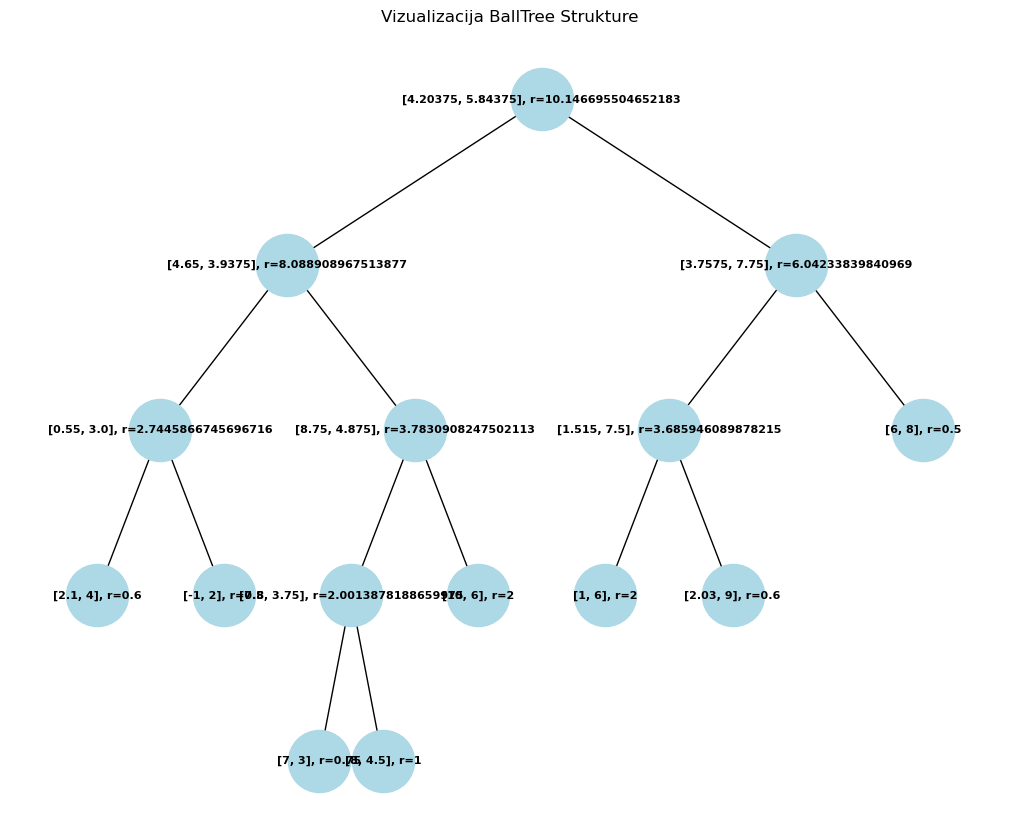

In [10]:
import networkx as nx

def plot_ball_tree(node, pos=None, level=0, x=0, dx=1.0, graph=None, labels=None):
    """ Pomoćna funkcija za rekursivno crtanje BallTree strukture. """
    if pos is None:
        pos = {}
    if graph is None:
        graph = nx.Graph()
    if labels is None:
        labels = {}

    pos[node] = (x, -level)
    labels[node] = f"{node.ball.coordinates}, r={node.ball.radius}"

    # Ako ima levog deteta, dodaj u graf i rekurzivno pozovi za levo dete
    if node.left is not None:
        graph.add_edge(node, node.left)
        plot_ball_tree(node.left, pos=pos, level=level + 1, x=x - dx, dx=dx / 2, graph=graph, labels=labels)
    # Ako ima desnog deteta, dodaj u graf i rekurzivno pozovi za desno dete
    if node.right is not None:
        graph.add_edge(node, node.right)
        plot_ball_tree(node.right, pos=pos, level=level + 1, x=x + dx, dx=dx / 2, graph=graph, labels=labels)

    return graph, pos, labels

# Kreiranje grafa, pozicije i labele iz BallTree strukture
graph, pos, labels = plot_ball_tree(tree.root)

# Crtanje grafa
plt.figure(figsize=(10, 8))
nx.draw(graph, pos, labels=labels, with_labels=True, node_size=2000, node_color='lightblue', font_size=8, font_weight='bold')
plt.title('Vizualizacija BallTree Strukture')
plt.savefig('results/bottom_up_graph1.png')
plt.show()

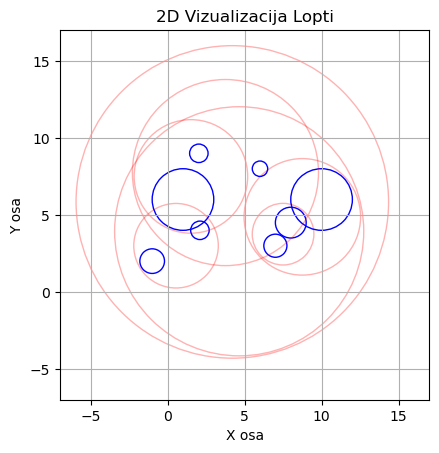

In [11]:
def plot_ball(ax, ball, color='b', alpha=1.0):
    """ Pomoćna funkcija za crtanje kruga. """
    circle = plt.Circle(ball.coordinates, ball.radius, color=color, fill=False, alpha=alpha)
    ax.add_artist(circle)

def plot_tree(node, ax, level=0, max_level=10):
    """ Rekurzivno prolazi kroz BallTree i crta sve lopte. """
    if node is None or level > max_level:
        return
    plot_ball(ax, node.ball, color='r' if node.left or node.right else 'b', alpha=0.3 if node.left or node.right else 1.0)
    plot_tree(node.left, ax, level+1, max_level)
    plot_tree(node.right, ax, level+1, max_level)

# Kreiranje grafika
fig, ax = plt.subplots()
ax.set_aspect('equal', 'box')

# Dodavanje lopti iz BallTree strukture
plot_tree(tree.root, ax)

# Podesavanje osa
ax.set_xlim(-7, 17)
ax.set_ylim(-7, 17)

# Prikazivanje grafika
plt.grid(True)
plt.xlabel('X osa')
plt.ylabel('Y osa')
plt.title('2D Vizualizacija Lopti')

plt.savefig('results/bottom_up1.png')

plt.show()

In [12]:
# testiranje na vecem skupu

In [13]:
np.random.seed(42)
balls2= []
for _ in range(20):
    x = np.random.random() * 30
    y = np.random.random() * 30
    r = 1
    ball = Ball([x, y], r)
    balls2.append(ball)

In [14]:
tree = BallTree()
for ball in balls2:
    node = BallTreeNode(True)
    node.ball = ball
    tree.nodes.append(node)
for node in tree.nodes:
    best_pair = tree.best_node_to_ball(node)
    vol = tree.best_vol_to_ball(node)
    elem = FringeElement(node, vol)
    heapq.heappush(tree.frng, elem)
while tree.root == None:
    b1, b2 = tree.find_best_pair()
    tree.merge_best_pair(b1, b2)

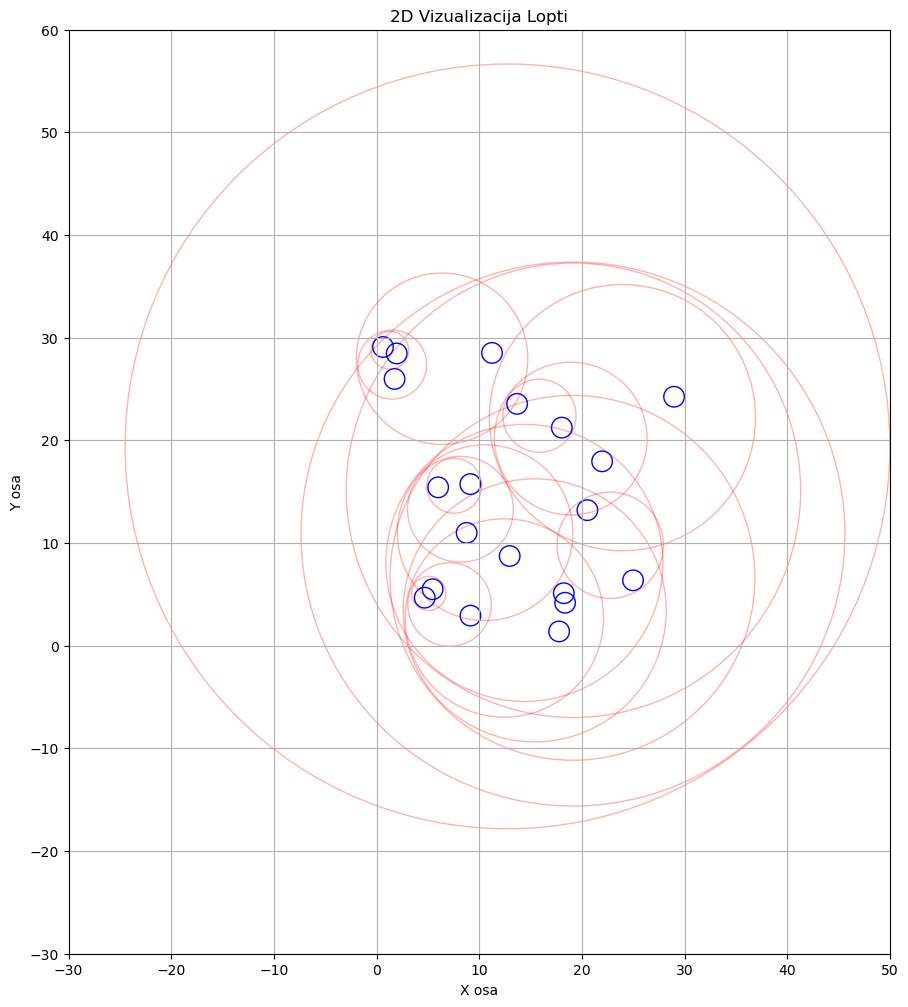

In [15]:
# Kreiranje grafika
fig, ax = plt.subplots(figsize=(12, 12))

ax.set_aspect('equal', 'box')

# Dodavanje lopti iz BallTree strukture
plot_tree(tree.root, ax)

# Podesavanje osa
ax.set_xlim(-30, 50)
ax.set_ylim(-30, 60)

# Prikazivanje grafika
plt.grid(True)
plt.xlabel('X osa')
plt.ylabel('Y osa')
plt.title('2D Vizualizacija Lopti')
plt.savefig('results/bottom_up2.png')

plt.show()

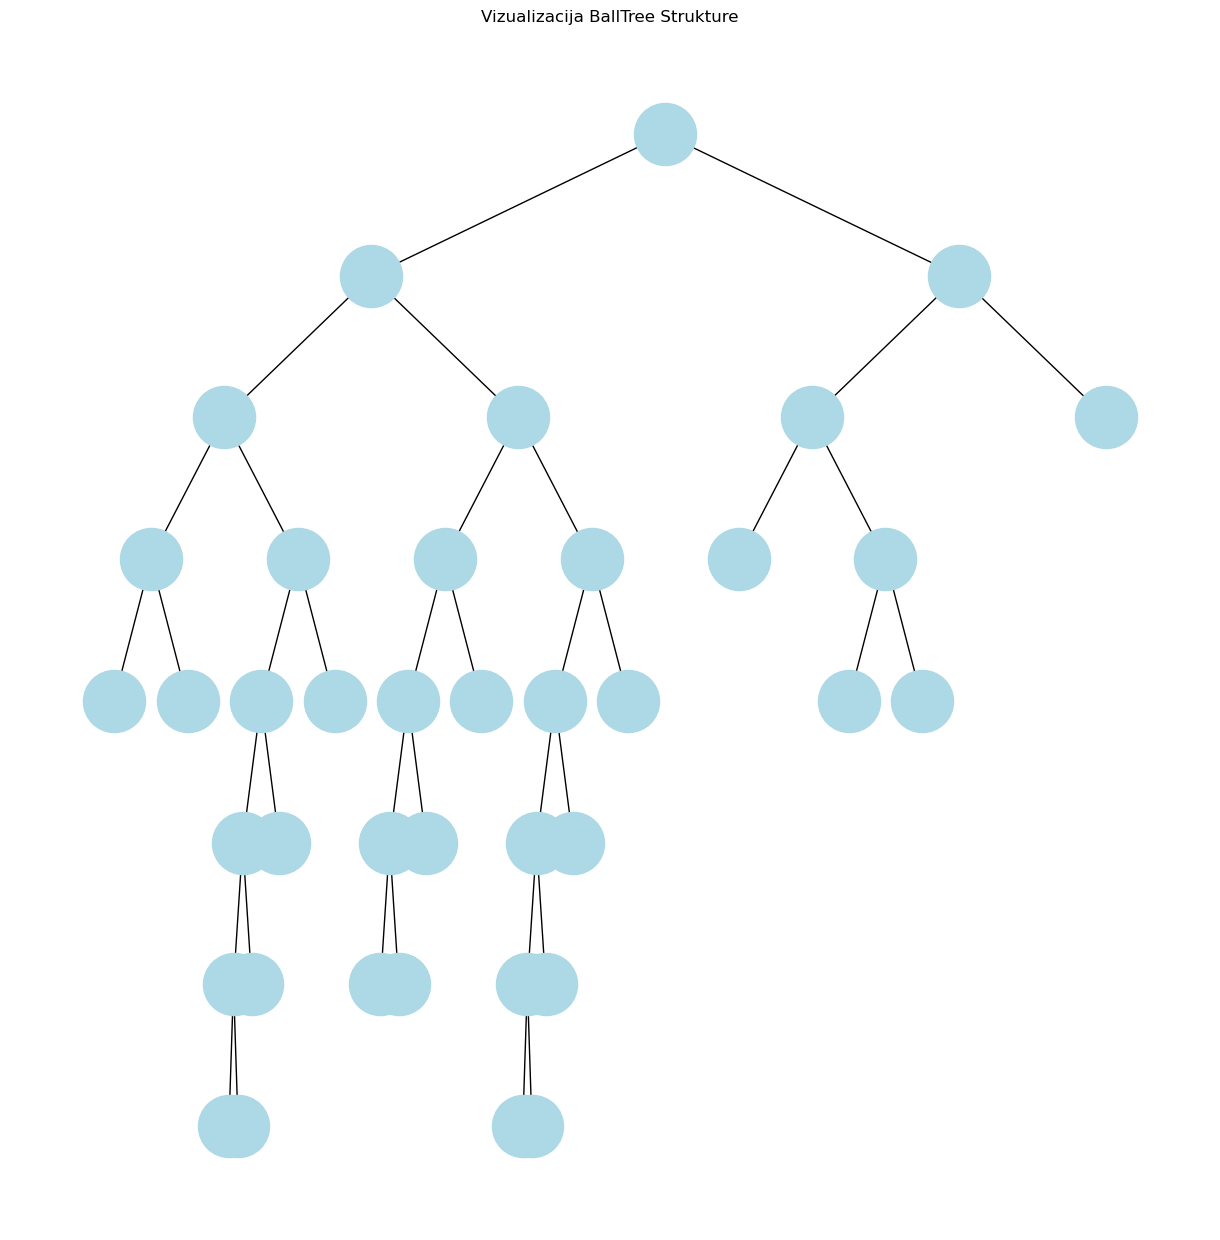

In [16]:
# Kreiranje grafa, pozicije i labele iz BallTree strukture
graph, pos, labels = plot_ball_tree(tree.root)

# Crtanje grafa
plt.figure(figsize=(12, 12))
nx.draw(graph, pos, node_size=2000, node_color='lightblue', font_size=8, font_weight='bold')
plt.title('Vizualizacija BallTree Strukture')
plt.savefig('results/bottom_up_graph2.png')
plt.show()

In [17]:
# merenje vremena izvrsavanja

import time

np.random.seed(42)
balls3= []
vol_leaf = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 110, 120, 130, 140, 150, 160, 170, 190, 200]
result_time = []
for v in vol_leaf:
    for _ in range(v):
        x = np.random.random() * 100
        y = np.random.random() * 100
        r = 1
        ball = Ball([x, y], r)
        balls3.append(ball)
    tree = BallTree()
    for ball in balls3:
        node = BallTreeNode(True)
        node.ball = ball
        tree.nodes.append(node)
    start_time = time.time()
    for node in tree.nodes:
        best_pair = tree.best_node_to_ball(node)
        vol = tree.best_vol_to_ball(node)
        elem = FringeElement(node, vol)
        heapq.heappush(tree.frng, elem)
    while tree.root == None:
        b1, b2 = tree.find_best_pair()
        tree.merge_best_pair(b1, b2)
    end_time = time.time()
    result_time.append(end_time-start_time)

In [18]:
result_time

[0.001191854476928711,
 0.007308006286621094,
 0.011829614639282227,
 0.02675795555114746,
 0.02620077133178711,
 0.051900386810302734,
 0.07681965827941895,
 0.11859703063964844,
 0.1933269500732422,
 0.24600577354431152,
 0.5318050384521484,
 0.5961980819702148,
 0.7207856178283691,
 0.9339165687561035,
 1.1853580474853516,
 1.5799651145935059,
 2.13153338432312,
 2.8832030296325684,
 2.7279152870178223,
 3.392099142074585,
 4.22404670715332,
 5.6433000564575195,
 7.340153455734253,
 7.616848707199097,
 8.884550333023071,
 11.11832332611084,
 13.26145625114441,
 15.197951316833496]

In [19]:
with open('bottom_up_time.txt', 'w') as f:
    for x in result_time:
        f.write(f'{x}\n')